In [2]:
# !pip install torchaudio==0.9.0
import torch
import torchaudio
import numpy as np
from tqdm.auto import tqdm
import torch.nn as nn
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader



## 0. Download dataset
- `wget` is a linux command to download a file from web

In [3]:
!wget http://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.001
!wget http://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.002
!wget http://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.003

--2021-10-29 11:27:11--  http://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.001
Resolving mi.soi.city.ac.uk (mi.soi.city.ac.uk)... 138.40.249.126
Connecting to mi.soi.city.ac.uk (mi.soi.city.ac.uk)|138.40.249.126|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mirg.city.ac.uk/datasets/magnatagatune/mp3.zip.001 [following]
--2021-10-29 11:27:12--  https://mirg.city.ac.uk/datasets/magnatagatune/mp3.zip.001
Resolving mirg.city.ac.uk (mirg.city.ac.uk)... 138.40.249.131
Connecting to mirg.city.ac.uk (mirg.city.ac.uk)|138.40.249.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100000000 (1.0G) [application/zip]
Saving to: 'mp3.zip.001.1'

mp3.zip.001.1         9%[>                   ]  96.76M   174KB/s    eta 75m 2s ^C
--2021-10-29 11:34:51--  http://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.002
Resolving mi.soi.city.ac.uk (mi.soi.city.ac.uk)... 138.40.249.126
Connecting to mi.soi.city.ac.uk (mi.soi.c

- Concatenate the zip files and unzip it

In [ ]:
!cat mp3.zip.* > mp3_all.zip
!unzip -q mp3_all.zip -d MTAT/

- Download meta data

In [ ]:
!wget http://mi.soi.city.ac.uk/datasets/magnatagatune/annotations_final.csv -P MTAT/
!wget http://mi.soi.city.ac.uk/datasets/magnatagatune/clip_info_final.csv -P MTAT/


--2021-10-11 06:32:10--  http://mi.soi.city.ac.uk/datasets/magnatagatune/annotations_final.csv
Resolving mi.soi.city.ac.uk (mi.soi.city.ac.uk)... 138.40.249.126
Connecting to mi.soi.city.ac.uk (mi.soi.city.ac.uk)|138.40.249.126|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mirg.city.ac.uk/datasets/magnatagatune/annotations_final.csv [following]
--2021-10-11 06:32:11--  https://mirg.city.ac.uk/datasets/magnatagatune/annotations_final.csv
Resolving mirg.city.ac.uk (mirg.city.ac.uk)... 138.40.249.131
Connecting to mirg.city.ac.uk (mirg.city.ac.uk)|138.40.249.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21517373 (21M) [text/csv]
Saving to: ‘mtat_dataset/annotations_final.csv’

annotations_final.c 100%[===================>]  20.52M  6.25MB/s    in 3.3s    

2021-10-11 06:32:16 (6.25 MB/s) - ‘mtat_dataset/annotations_final.csv’ saved [21517373/21517373]

--2021-10-11 06:32:16--  http://mi.soi.city.ac.uk/data

## 1. Look at the Dataset

In [3]:
data_dir = Path('../MTAT/')

In [4]:
meta = pd.read_csv(data_dir / "clip_info_final.csv", delimiter='\t')
labels = pd.read_csv(data_dir / "annotations_final.csv", delimiter='\t')

In [5]:
meta.head()

,clip_id,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url,mp3_path
0,2,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,30,59,http://he3.magnatune.com/all/01--BWV54%20-%20I...,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,146,175,http://he3.magnatune.com/all/01--BWV54%20-%20I...,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,262,291,http://he3.magnatune.com/all/01--BWV54%20-%20I...,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,291,320,http://he3.magnatune.com/all/01--BWV54%20-%20I...,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,320,349,http://he3.magnatune.com/all/01--BWV54%20-%20I...,f/american_bach_soloists-j_s__bach_solo_cantat...


In [6]:
labels.head()

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...


In [6]:
tag = [key for key in labels.keys() if not key in ('clip_id', 'mp3_path')]
len(tag), tag[:10]

(188,
 ['no voice',
  'singer',
  'duet',
  'plucking',
  'hard rock',
  'world',
  'bongos',
  'harpsichord',
  'female singing',
  'clasical'])

- Some of the tags have different name but represents almost same things
- Below are the example of defining synonyms among tags

In [7]:
# From https://github.com/keunwoochoi/magnatagatune-list
synonyms = [['beat', 'beats'],
			['chant', 'chanting'],
			['choir', 'choral'],
			['classical', 'clasical', 'classic'],
			['drum', 'drums'],
			['electro', 'electronic', 'electronica', 'electric'],
			['fast', 'fast beat', 'quick'],
			['female', 'female singer', 'female singing', 'female vocals', 'female voice', 'woman', 'woman singing', 'women'],
			['flute', 'flutes'],
			['guitar', 'guitars'],
			['hard', 'hard rock'],
			['harpsichord', 'harpsicord'],
			['heavy', 'heavy metal', 'metal'],
			['horn', 'horns'],
			['india', 'indian'],
			['jazz', 'jazzy'],
			['male', 'male singer', 'male vocal', 'male vocals', 'male voice', 'man', 'man singing', 'men'],
			['no beat', 'no drums'],
			['no singer', 'no singing', 'no vocal','no vocals', 'no voice', 'no voices', 'instrumental'],
			['opera', 'operatic'],
			['orchestra', 'orchestral'],
			['quiet', 'silence'],
			['singer', 'singing'],
			['space', 'spacey'],
			['string', 'strings'],
			['synth', 'synthesizer'],
			['violin', 'violins'],
			['vocal', 'vocals', 'voice', 'voices'],
			['strange', 'weird']]

In [8]:
labels = pd.read_csv(data_dir / "annotations_final.csv", delimiter='\t')
for syn in synonyms:
  for i in range(1, len(syn)):
    labels[syn[0]] += labels[syn[1]]
  labels = labels.drop(columns=syn[1:])
  labels[syn[0]] = np.minimum(labels['beat'].values, 1)
tag = [key for key in labels.keys() if not key in ('clip_id', 'mp3_path')]
len(tag), tag[:10]
labels

,clip_id,singer,duet,plucking,world,bongos,harpsichord,sitar,chorus,female opera,...,soft,noise,choir,rap,hip hop,water,baroque,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25858,58899,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8/jacob_heringman-blame_not_my_lute-56-la_bres...
25859,58906,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8/jacob_heringman-blame_not_my_lute-57-lost_is...
25860,58907,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8/jacob_heringman-blame_not_my_lute-57-lost_is...
25861,58908,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8/jacob_heringman-blame_not_my_lute-57-lost_is...


In [9]:
class MTATDataset:
  def __init__(self, dir, top_k=50, min_tag_occur=1, synonyms=(), max_num_data=None, sr=16000, split='train'):
    self.dir = dir
    self.meta = pd.read_csv(dir / "clip_info_final.csv", delimiter='\t')
    self.labels = pd.read_csv(dir / "annotations_final.csv", delimiter='\t')
    self.sr = sr

    self.get_tag_names()
    self.combine_tags(synonyms)
    self.filter_top_k_tags(top_k)
    self.filter_minimum_tag(min_tag_occur)

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    else: #test
      sub_dir_ids = ['e', 'f', 'g']

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]
    is_pt_file_exists = [(self.dir/x).with_suffix('.pt').exists() for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_pt_file_exists]
    
    if max_num_data and max_num_data < len(self.labels):
      self.labels = self.labels.sample(max_num_data)
      # self.labels = self.labels.iloc[:max_num_data]

    self.vocab = self.labels.columns.values[1:-1]
    # self.audios = self.load_audio()
#     self.audios = self.load_pre_processed_data()
    self.label_tensor = self.convert_label_to_tensor()

  def get_tag_names(self):
    self.tag_names = [key for key in self.labels.keys() if not key in ('clip_id', 'mp3_path')]

  def combine_tags(self, synonyms):
    for syn in synonyms:
      for i in range(1, len(syn)):
        self.labels[syn[0]] += self.labels[syn[i]]
      self.labels = self.labels.drop(columns=syn[1:])
      self.labels[syn[0]] = np.minimum(self.labels[syn[0]].values, 1)
    self.get_tag_names()

  def clip_id_to_tag(self, clip_id):
    return torch.Tensor(self.labels[self.labels['clip_id']==clip_id].values[0,1:-1].astype(int))

  def filter_top_k_tags(self, k=50):
    tag_count = [sum(self.labels[tag]) for tag in self.tag_names]
    descending_sorted_idx = sorted(range(len(tag_count)), key=lambda k: -tag_count[k])
    filtered_tag_names = np.asarray(self.tag_names)[descending_sorted_idx[:k]].tolist()
    for tag in self.tag_names:
      if tag not in filtered_tag_names:
        self.labels = self.labels.drop(columns=tag)
    self.tag_names = filtered_tag_names
  
  def filter_minimum_tag(self, min_tag=1):
    tag_occurs_by_song = np.sum(self.labels[self.tag_names].values, axis=1)
    self.labels = self.labels.drop(index=np.where(tag_occurs_by_song < min_tag)[0])

  def load_audio(self):
    audios = []
    fail_idx = []
    for idx in tqdm(range(len(self.labels))):
      try:
        audio, sr = torchaudio.load(self.dir / self.labels.iloc[idx]['mp3_path'])
        if sr != self.sr:
          audio = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sr)(audio)
        audios.append(audio)
      # try
      except:
        fail_idx.append(idx)
    self.labels = self.labels.drop(index=fail_idx)
    return audios

  def load_pre_processed_data(self):
    audios = [torch.load( (self.dir / self.labels.iloc[idx]['mp3_path']).with_suffix('.pt'))['audio'][0] for idx in tqdm(range(len(self.labels)))]
    return audios

  def convert_label_to_tensor(self):
    return torch.LongTensor(self.labels.values[:, 1:-1].astype('bool'))

  def __getitem__(self, idx):
#     audio = self.audios[idx]
    audio = torch.load((self.dir / self.labels.iloc[idx]['mp3_path']).with_suffix('.pt'))['audio'][0]
    tag = self.label_tensor[idx]
    return audio, tag

  def __len__(self):
    return len(self.labels)


dataset = MTATDataset(data_dir, top_k=50,  synonyms=synonyms)
valid_dataset= MTATDataset(data_dir, top_k=50, synonyms=synonyms, split='valid')
test_dataset = MTATDataset(data_dir, top_k=50,  synonyms=synonyms, split='test')

In [10]:
dataset.labels

,clip_id,singer,harpsichord,sitar,heavy,foreign,no piano,classical,female,jazz,...,rock,dance,cello,techno,flute,beat,soft,choir,baroque,mp3_path
5,14,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-30-59.mp3
7,21,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-233-262.mp3
8,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-291-320.mp3
10,29,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...
16,39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9/american_bach_soloists-heinrich_schutz__musi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25858,58899,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8/jacob_heringman-blame_not_my_lute-56-la_bres...
25859,58906,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,8/jacob_heringman-blame_not_my_lute-57-lost_is...
25860,58907,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,8/jacob_heringman-blame_not_my_lute-57-lost_is...
25861,58908,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,8/jacob_heringman-blame_not_my_lute-57-lost_is...


In [12]:
entire_sets = [dataset, valid_dataset, test_dataset]
filtered_meta = pd.concat([x.labels for x in entire_sets])


In [13]:
filtered_meta

,clip_id,singer,harpsichord,sitar,heavy,foreign,no piano,classical,female,jazz,...,rock,dance,cello,techno,flute,beat,soft,choir,baroque,mp3_path
5,14,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-30-59.mp3
7,21,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-233-262.mp3
8,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-291-320.mp3
10,29,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...
16,39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9/american_bach_soloists-heinrich_schutz__musi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25751,58479,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/jacob_heringman_and_catherine_king-alonso_mu...
25798,58605,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/jacob_heringman_and_catherine_king-alonso_mu...
25799,58606,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,f/jacob_heringman_and_catherine_king-alonso_mu...
25800,58608,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,f/jacob_heringman_and_catherine_king-alonso_mu...


In [102]:
def copy_pt_files(trainset, validset, testset, filt_data_dir = Path('../MTAT_SMALL')):
  import shutil
  entire_sets = [trainset, validset, testset]
  filtered_meta = pd.concat([x.labels for x in entire_sets])
  filt_data_dir.mkdir(exist_ok=True)
  filtered_meta.to_csv(filt_data_dir/'meta.csv')
  for mp3_path in tqdm(filtered_meta['mp3_path']):
    new_path = filt_data_dir / mp3_path
    new_path.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy((data_dir/mp3_path), new_path)

# copy_pt_files(dataset, valid_dataset, test_dataset)

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False, num_workers=4)
batch = next(iter(train_loader))
batch

[tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.2187e-06,
           4.8876e-06,  3.0398e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -7.7486e-07,
          -7.1526e-07, -5.9605e-08],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  6.1393e-06,
           7.0930e-06,  7.5102e-06],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.7881e-07,
          -5.9605e-08, -2.9802e-07],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  2.3246e-06,
           8.3447e-07,  8.9407e-07],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           5.9605e-08, -2.9802e-07]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0]])]

In [8]:
torch.Tensor([0]).cuda()

tensor([0.], device='cuda:0')

In [17]:
import IPython.display as ipd
ipd.display(ipd.Audio(batch[0][1], rate=16000))

dataset.vocab

array(['singer', 'harpsichord', 'sitar', 'heavy', 'foreign', 'no piano',
       'classical', 'female', 'jazz', 'guitar', 'quiet', 'solo', 'folk',
       'ambient', 'new age', 'synth', 'drum', 'bass', 'loud', 'string',
       'opera', 'fast', 'country', 'violin', 'electro', 'trance', 'chant',
       'strange', 'modern', 'hard', 'harp', 'pop', 'female vocal',
       'piano', 'orchestra', 'eastern', 'slow', 'male', 'vocal',
       'no singer', 'india', 'rock', 'dance', 'cello', 'techno', 'flute',
       'beat', 'soft', 'choir', 'baroque'], dtype=object)

In [29]:
dataset.vocab[batch[1][1]==1]

array(['heavy', 'male', 'vocal', 'rock'], dtype=object)

## Make model

In [24]:
class AudioSpecModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels) -> None:
    super().__init__()
    self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()
    self.batch_norm = nn.BatchNorm1d(n_mels)
  
  def forward(self, x):
    mel_spec = self.mel_converter(x)
    db_spec = self.db_converter(mel_spec)
    return self.batch_norm(db_spec)

class AudioModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels, num_output, hidden_size):
    super().__init__()
    self.mel = AudioSpecModel(sr, n_fft, hop_length, n_mels)
    self.conv_layer = nn.Sequential(
      nn.Conv1d(n_mels, out_channels=hidden_size, kernel_size=3),
      nn.BatchNorm1d(hidden_size),
      nn.MaxPool1d(2),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.BatchNorm1d(hidden_size),
      nn.MaxPool1d(2),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.BatchNorm1d(hidden_size),
      nn.MaxPool1d(2),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.BatchNorm1d(hidden_size),
      nn.MaxPool1d(2),
      nn.ReLU()
    )
    self.final_layer = nn.Linear(hidden_size, num_output)
  def get_spec(self, x):
    return self.mel(x)
  def get_embedding(self,x):
    spec = self.mel(x)
    return self.conv_layer(spec)
    
  def forward(self, x):
    spec = self.mel(x) # N X MEL X L (Time)
    conv_output = self.conv_layer(spec) # N X OutChannel X L_out
    linear_out = self.final_layer(conv_output.permute(0,2,1))
    linear_out = torch.max(linear_out, dim=1)[0]
#     max_output = torch.max(conv_output, dim=-1)[0]
#     linear_out = self.final_layer(max_output)
    return linear_out.sigmoid()



model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
spec_converter = AudioSpecModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48)


In [17]:
batch[1].long()

NameError: name 'batch' is not defined

In [25]:
def get_accuracy(pred, target, threshold=0.5):
  return torch.mean( ((pred>threshold)==target).float() ) 

def get_tpr_fnr(pred, target, threshold=0.5):
  thresh_pred = pred> threshold
  p = torch.sum(target == 1)
  tp = torch.sum((thresh_pred==1) * (target==1))
  n = torch.sum(target == 0)
  fn = torch.sum((thresh_pred==1) * (target==0))
  
  return tp/p, fn/n

def get_precision_recall(pred, target, threshold=0.5):
  thresh_pred = pred> threshold
  answer_positive = torch.sum(thresh_pred == 1)
  if answer_positive==0:
    answer_positive=1
  p = torch.sum(target == 1)
  tp = torch.sum((thresh_pred==1) * (target==1))
  
  return tp / answer_positive, tp/p

def get_pr_auc(pred, label, num_grid=500):
  auc = 0
  prev_recall= 0
  for thresh in reversed(torch.linspace(0,1,num_grid)):
    precision, recall = get_precision_recall(pred, label, threshold=thresh)
    auc += precision * (recall-prev_recall)
    prev_recall = recall
  return auc


def get_roc_auc(pred, label, num_grid=500):
  auc = 0
  prev_fpr = 0
  for thresh in reversed(torch.linspace(0,1,num_grid)):
    tpr, fpr = get_tpr_fnr(pred, label, threshold=thresh)
    auc += tpr * (fpr-prev_fpr)
    prev_fpr = fpr
  return auc

def plot_roc_auc_curve(pred, label, num_grid=500):
  tprs = []
  fprs = [] 
  for thresh in reversed(torch.linspace(0,1,num_grid)):
    tpr, fpr = get_tpr_fnr(pred, label, threshold=thresh)
    tprs.append(tpr)
    fprs.append(fpr)
  plt.plot(fprs, tprs)

def plot_precision_recall_curve():
  return

In [26]:
def train_model(model, train_loader, valid_loader, optimizer, num_epochs, loss_func, device='cuda'):
  loss_records =[] 
  valid_acc_records = []
  model.train()
  for epoch in tqdm(range(num_epochs)):
    for batch in train_loader:
      optimizer.zero_grad()
      audio, label = batch
      pred = model(audio.to(device))
      loss = loss_func(pred, label.float().to(device))
      loss.backward()
      optimizer.step()
      loss_records.append(loss.item())
    valid_acc = validate_model(model, valid_loader, device)
    valid_acc_records.append(valid_acc.item())
    print(f"Epoch: {epoch+1} / Acc = {valid_acc.item()} / Best_acc = {max(valid_acc_records)}")
    if valid_acc.item() == max(valid_acc_records):
      torch.save(model.state_dict(), "auto_tagging_full_trainingset_bn_best.pt")
  return {"loss": loss_records, "valid_acc": valid_acc_records}

def validate_model(model, valid_loader, device):
  valid_acc = 0
  model.eval()
  with torch.no_grad():
    for batch in valid_loader:
      audio, label = batch
      pred = model(audio.to(device))
#       auc = get_roc_auc(pred, label.to(device))
      auc = get_pr_auc(pred, label.to(device))
      valid_acc += auc * len(label)
  model.train()
  return valid_acc / len(valid_loader.dataset)


model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=48, num_output=50, hidden_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = model.to('cuda')
loss_func = torch.nn.BCELoss()
train_record = train_model(model, train_loader, valid_loader, optimizer, 50, loss_func )
torch.save(model.state_dict(), "auto_tagging_full_trainingset_bn_last.pt")

  0%|          | 0/50 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 1 / Acc = 0.07256507128477097 / Best_acc = 0.07256507128477097


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 2 / Acc = 0.10983046144247055 / Best_acc = 0.10983046144247055


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 3 / Acc = 0.1635231226682663 / Best_acc = 0.1635231226682663


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 4 / Acc = 0.19805997610092163 / Best_acc = 0.19805997610092163


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 5 / Acc = 0.2453717291355133 / Best_acc = 0.2453717291355133


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 6 / Acc = 0.2721587121486664 / Best_acc = 0.2721587121486664


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 7 / Acc = 0.3133966028690338 / Best_acc = 0.3133966028690338


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280><function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getp

Epoch: 8 / Acc = 0.3330601453781128 / Best_acc = 0.3330601453781128


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 9 / Acc = 0.3660525977611542 / Best_acc = 0.3660525977611542


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 10 / Acc = 0.37866443395614624 / Best_acc = 0.37866443395614624


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 11 / Acc = 0.37518250942230225 / Best_acc = 0.37866443395614624


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 12 / Acc = 0.3949725925922394 / Best_acc = 0.3949725925922394


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 13 / Acc = 0.41463980078697205 / Best_acc = 0.41463980078697205


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>    
if w.is_alive():Traceback (most recent call last):

  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
AssertionError:     can only test a child processif w.is_alive():

Epoch: 14 / Acc = 0.40136346220970154 / Best_acc = 0.41463980078697205


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 15 / Acc = 0.4234081208705902 / Best_acc = 0.4234081208705902


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 16 / Acc = 0.42007219791412354 / Best_acc = 0.4234081208705902


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 17 / Acc = 0.4424564242362976 / Best_acc = 0.4424564242362976


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 18 / Acc = 0.445109486579895 / Best_acc = 0.445109486579895


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 19 / Acc = 0.4565126895904541 / Best_acc = 0.4565126895904541


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>if w.is_alive():

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

AssertionError  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
: can only test a child process    
if w.is_alive()

Epoch: 20 / Acc = 0.45104601979255676 / Best_acc = 0.4565126895904541


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
AssertionError:     can only test a child processself._shutdown_workers()

  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 21 / Acc = 0.46473291516304016 / Best_acc = 0.46473291516304016


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767489c280>
Traceback (most recent call last):
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/teo/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive()

Epoch: 22 / Acc = 0.4602113664150238 / Best_acc = 0.46473291516304016
Epoch: 23 / Acc = 0.4656730890274048 / Best_acc = 0.4656730890274048
Epoch: 24 / Acc = 0.47233590483665466 / Best_acc = 0.47233590483665466
Epoch: 25 / Acc = 0.46765846014022827 / Best_acc = 0.47233590483665466
Epoch: 26 / Acc = 0.4744240641593933 / Best_acc = 0.4744240641593933
Epoch: 27 / Acc = 0.4690879285335541 / Best_acc = 0.4744240641593933
Epoch: 28 / Acc = 0.47543367743492126 / Best_acc = 0.47543367743492126
Epoch: 29 / Acc = 0.471356064081192 / Best_acc = 0.47543367743492126
Epoch: 30 / Acc = 0.4750761091709137 / Best_acc = 0.47543367743492126
Epoch: 31 / Acc = 0.47593531012535095 / Best_acc = 0.47593531012535095
Epoch: 32 / Acc = 0.46866869926452637 / Best_acc = 0.47593531012535095
Epoch: 33 / Acc = 0.4749331772327423 / Best_acc = 0.47593531012535095
Epoch: 34 / Acc = 0.4897385537624359 / Best_acc = 0.4897385537624359
Epoch: 35 / Acc = 0.48602694272994995 / Best_acc = 0.4897385537624359
Epoch: 36 / Acc = 0.

In [27]:
best_state = torch.load('auto_tagging_full_trainingset_bn_best.pt')

In [32]:
dataset.vocab.tolist()

['singer',
 'harpsichord',
 'sitar',
 'heavy',
 'foreign',
 'no piano',
 'classical',
 'female',
 'jazz',
 'guitar',
 'quiet',
 'solo',
 'folk',
 'ambient',
 'new age',
 'synth',
 'drum',
 'bass',
 'loud',
 'string',
 'opera',
 'fast',
 'country',
 'violin',
 'electro',
 'trance',
 'chant',
 'strange',
 'modern',
 'hard',
 'harp',
 'pop',
 'female vocal',
 'piano',
 'orchestra',
 'eastern',
 'slow',
 'male',
 'vocal',
 'no singer',
 'india',
 'rock',
 'dance',
 'cello',
 'techno',
 'flute',
 'beat',
 'soft',
 'choir',
 'baroque']

In [34]:
torch.save({'state':best_state, 'vocab':dataset.vocab}, 'auto_tagging_full_trainingset_bn_best.pt')

In [24]:
validate_model(model, valid_loader, 'cuda')

tensor(0.4684, device='cuda:0')

In [44]:
model.eval()
model.cpu()
test_sample = batch[0][0:1]
test_sample.requires_grad = True
out = model(test_sample)
out[0,0].backward()

In [61]:
indices = torch.where(test_sample.grad[0])[0]

In [63]:
indices[-1] - indices[0]

tensor(24062)

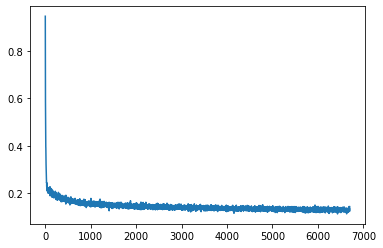

In [18]:
plt.plot(train_record['loss'])

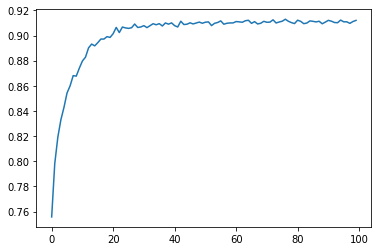

In [19]:
plt.plot(train_record['valid_acc'])

In [71]:
batch = next(iter(valid_loader))
audio, label = batch
pred  = model(audio[:16].cuda())

In [40]:
pred

tensor([[    0.0215,     0.2742,     0.0074,  ...,     0.0087,     0.0145,
             0.0230],
        [    0.0524,     0.0010,     0.0011,  ...,     0.0121,     0.0018,
             0.0000],
        [    0.6282,     0.0014,     0.0227,  ...,     0.0243,     0.0668,
             0.0019],
        ...,
        [    0.0021,     0.0000,     0.0021,  ...,     0.0074,     0.0002,
             0.0002],
        [    0.0007,     0.0003,     0.0025,  ...,     0.2326,     0.0005,
             0.0012],
        [    0.0269,     0.0056,     0.0040,  ...,     0.0716,     0.0036,
             0.0039]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [41]:
embedding = model.get_embedding(audio.cuda())

In [72]:
def get_embedding(self,x):
    spec = self.mel(x)
    return self.conv_layer[:-1](spec)
embedding = get_embedding(model, audio[:16].cuda()).cpu().detach().numpy()

In [73]:
embedding = embedding[:,10,:]

In [74]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X_embedded = PCA(n_components=2).fit_transform(embedding)


In [78]:
valid_loader.dataset.labels['mp3_path'].values[:16]

array(['d/seismic_anamoly-afterburner-02-snake_eyes-320-349.mp3',
       'd/shiva_in_exile-ethnic-02-breathing-0-29.mp3',
       'd/kyiv_chamber_choir-praise_the_lord-10-grechaninovthe_cherubic_hymn-146-175.mp3',
       'd/rapoon-vernal_crossing-07-anatapurrah-204-233.mp3',
       'd/shira_kammen-mistral-12-hanter_dros-88-117.mp3',
       'd/kyiv_chamber_choir-praise_the_lord-02-rachmaninovbless_the_lord_o_my_soul-233-262.mp3',
       'd/various_artists-the_art_of_persuasion-05-follow_your_bliss_paul_avgerinos-262-291.mp3',
       'd/tom_paul-there_is_no_map-02-shes_my_girlfriend-88-117.mp3',
       'd/paul_avgerinos-maya__the_great_katun-06-night_of_the_goddess_part_2-233-262.mp3',
       'd/magnatune_compilation-new_age_and_jazz-04-stellamara_immrama-30-59.mp3',
       'd/ambient_teknology-the_all_seeing_eye_project-01-cyclops-320-349.mp3',
       'd/electric_frankenstein-sick_songs-05-born_wild-146-175.mp3',
       'd/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-29

In [84]:
names = valid_loader.dataset.labels['mp3_path'].values[:16].tolist()

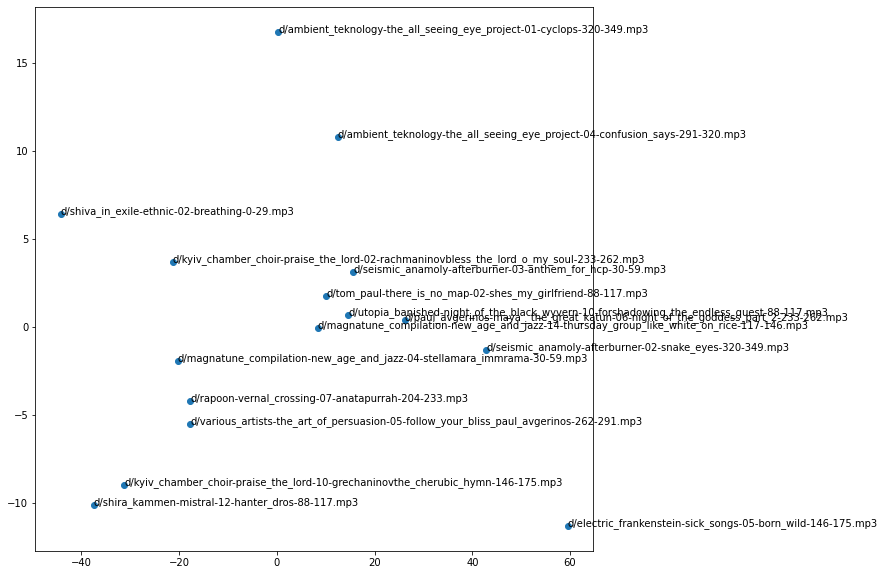

In [91]:
plt.figure(figsize=(10,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1])
for i in range(16):
    plt.text(X_embedded[i,0], X_embedded[i,1], names[i])

In [39]:
torch.set_printoptions(sci_mode=False)

In [86]:
batch[0].to('cuda')

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [78]:
torch.max(spec_converter(batch[0]), dim=1)

torch.return_types.max(
values=tensor([[-40.7118, -21.5218,  21.8099,  ...,  16.2576,  -3.4054, -85.3622],
        [-26.3913,  -7.5810,  25.9024,  ...,  24.5974,   3.7532, -69.6471],
        [-37.8599, -20.1594,  24.7856,  ...,  27.4672,   3.7065, -75.1246],
        ...,
        [-40.7829, -19.1795,  26.4167,  ...,  34.2211,  15.7194, -54.3557],
        [-28.5454,  -5.7235,  20.7069,  ...,  28.2244,   9.7189, -59.2974],
        [-54.0965, -34.0383,   9.5253,  ...,  22.8983,   5.0197, -81.2673]]),
indices=tensor([[10, 11,  6,  ...,  6,  6, 13],
        [22, 22, 21,  ..., 14,  6, 19],
        [ 5,  4,  7,  ...,  9,  9, 10],
        ...,
        [18, 26,  4,  ...,  7,  8,  9],
        [ 5,  5, 10,  ..., 12, 12,  9],
        [ 7, 10,  9,  ...,  6, 10, 21]]))

In [77]:
model(batch[0])

TypeError: linear(): argument 'input' (position 1) must be Tensor, not torch.return_types.max

In [ ]:
from collections import Counter
clip_counter = Counter(labels['clip_id'])

In [8]:
id_n_path = meta[['clip_id', 'mp3_path']].to_dict('records')
pt_files = list(data_dir.rglob('*.pt'))

25860

In [ ]:
id_n_path[0]['mp3_path']

'f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-30-59.mp3'

In [ ]:
mp3_path.exists()

True

In [10]:
def resample_files(id_n_path:list, data_dir:Path, labels, SR:int):
  SR = 16000
  for data_info in id_n_path:
    if not isinstance(data_info['mp3_path'], str):
      continue
    mp3_path = data_dir / data_info['mp3_path']
    if mp3_path.exists():
      try:
        y, sr = torchaudio.load(mp3_path)
      except:
        print(f'Failed to load {str(mp3_path)}')
        continue
      if sr != SR:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SR)
        y = resampler(y)
      label = labels[labels['clip_id']==data_info['clip_id']].values[0,1:-1].astype(int)
      torch.save({'audio':y, 'tag':torch.LongTensor(label)}, mp3_path.with_suffix('.pt'))

id_n_path = meta[['clip_id', 'mp3_path']].to_dict('records')


Failed to load ../MTAT/6/norine_braun-now_and_zen-08-gently-117-146.mp3
Failed to load ../MTAT/8/jacob_heringman-josquin_des_prez_lute_settings-19-gintzler__pater_noster-204-233.mp3
Failed to load ../MTAT/9/american_baroque-dances_and_suites_of_rameau_and_couperin-25-le_petit_rien_xiveme_ordre_couperin-88-117.mp3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.mkdir('mtat_dataset')

In [ ]:
for path in Path('.').glob('*'):
  if path in ['mtat_dataset', 'drive']:
    continue
  if path.is_dir() and len(str(path))==1:
    os.rename(path, 'mtat_dataset/'+str(path))

In [ ]:
!zip -r mtat.zip mtat_dataset

In [ ]:
import os
for pt_file in Path('mtat_dataset').rglob('*.pt'):
  os.rename(pt_file, 'mtat_pt/'+pt_file.name)

In [ ]:
test = next(Path('mtat_pt').rglob('*.pt'))

In [ ]:
test.name

'lvx_nova-lvx_nova-05-my_time-552-581.pt'

In [ ]:
!rm -rf mtat_pt/